In [ ]:
if(ENV_TYPE != "TEST"):
  !git clone "https://github.com/kk-digital/kcg-ml-sd1p4.git"
  %cd kcg-ml-sd1p4
  !pip3 install -r requirements.txt
  exit()
  base_directory = "./"
else:
  base_directory = "../"

# Magical check for fixing all of our directory issues
import subprocess
output = subprocess.check_output(["pwd"], universal_newlines=True)
if "notebooks" in output:
    %cd ..
del output

In [ ]:
%cd kcg-ml-sd1p4

In [ ]:
!python3 ./download_models.py

In [ ]:
!python3 ./process_models.py

Loading tokenizer and transformer...[DONE]	1,781.02ms
Sample...[DONE]	3,574.84ms


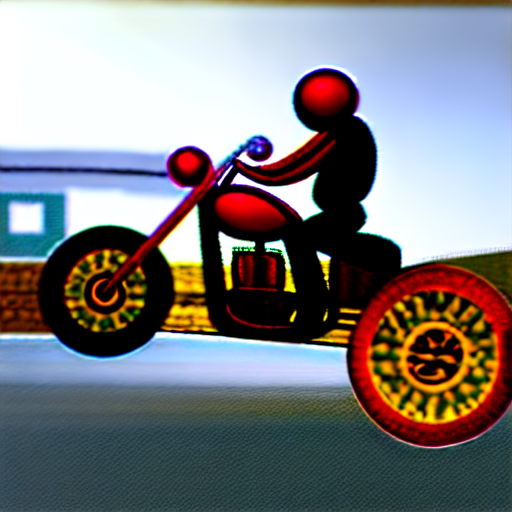

Image saved at /content/kcg-ml-sd1p4/output/sd2-notebook/disturbed_embeddings/images/generated_image_alpha_0.00.png
Sample...[DONE]	3,494.15ms


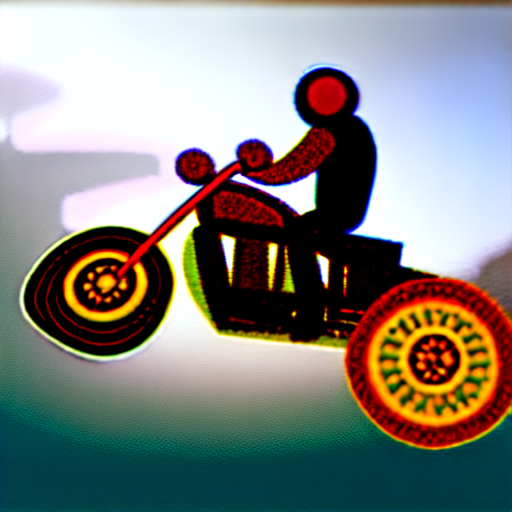

Image saved at /content/kcg-ml-sd1p4/output/sd2-notebook/disturbed_embeddings/images/generated_image_alpha_0.11.png
Sample...[DONE]	3,517.84ms


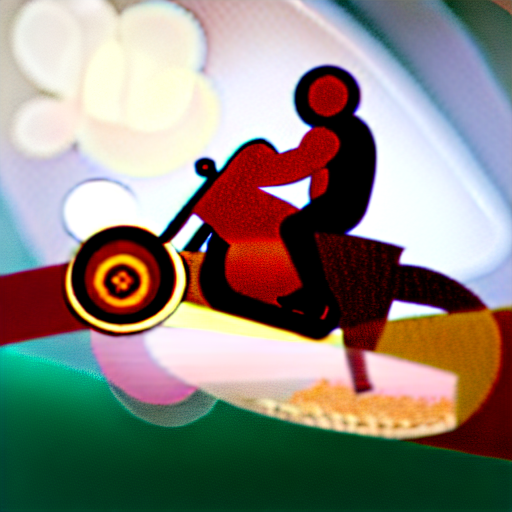

Image saved at /content/kcg-ml-sd1p4/output/sd2-notebook/disturbed_embeddings/images/generated_image_alpha_0.22.png
Sample...[DONE]	3,541.56ms


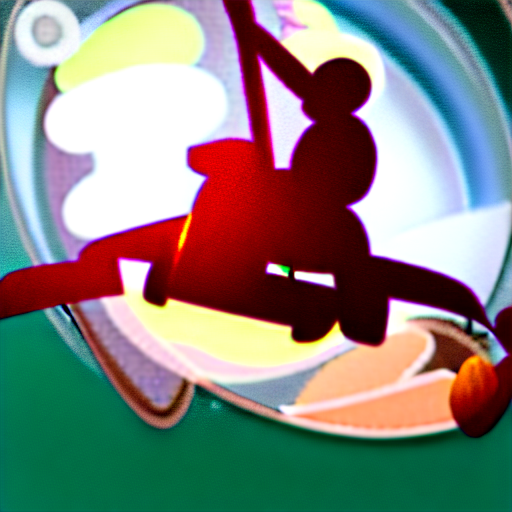

Image saved at /content/kcg-ml-sd1p4/output/sd2-notebook/disturbed_embeddings/images/generated_image_alpha_0.33.png
Sample...[DONE]	3,569.54ms


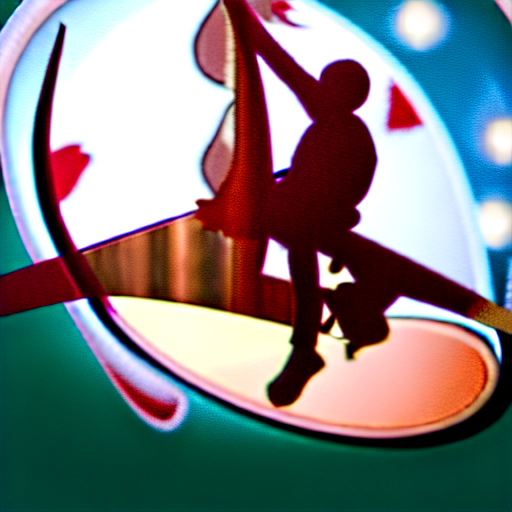

Image saved at /content/kcg-ml-sd1p4/output/sd2-notebook/disturbed_embeddings/images/generated_image_alpha_0.44.png
Sample...[DONE]	3,577.74ms


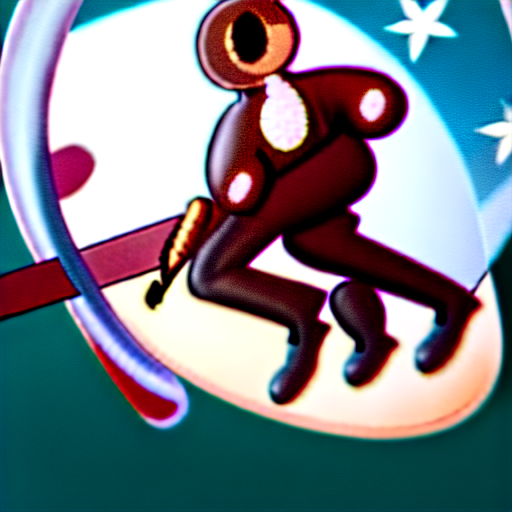

Image saved at /content/kcg-ml-sd1p4/output/sd2-notebook/disturbed_embeddings/images/generated_image_alpha_0.56.png
Sample...[DONE]	3,598.58ms


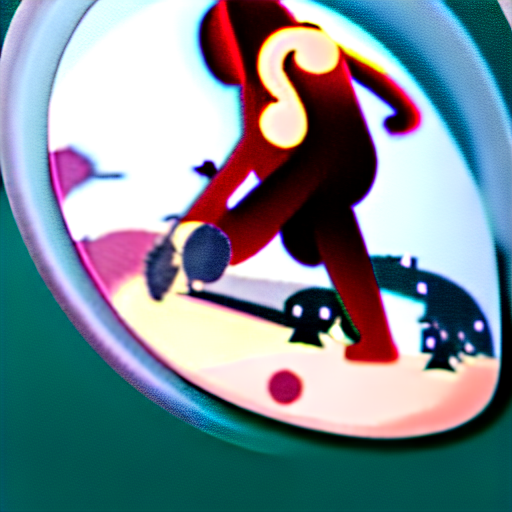

Image saved at /content/kcg-ml-sd1p4/output/sd2-notebook/disturbed_embeddings/images/generated_image_alpha_0.67.png
Sample...[DONE]	3,609.06ms


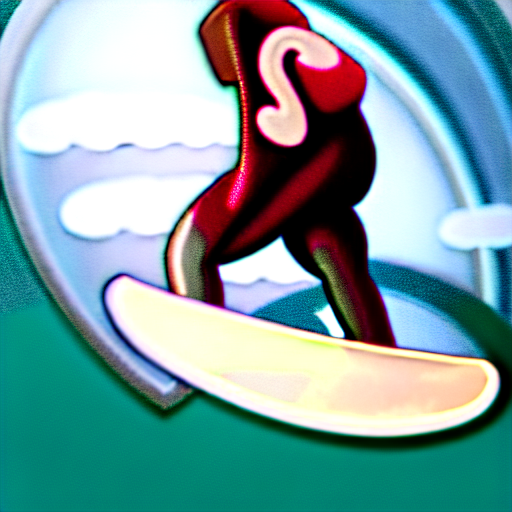

Image saved at /content/kcg-ml-sd1p4/output/sd2-notebook/disturbed_embeddings/images/generated_image_alpha_0.78.png
Sample...[DONE]	3,594.79ms


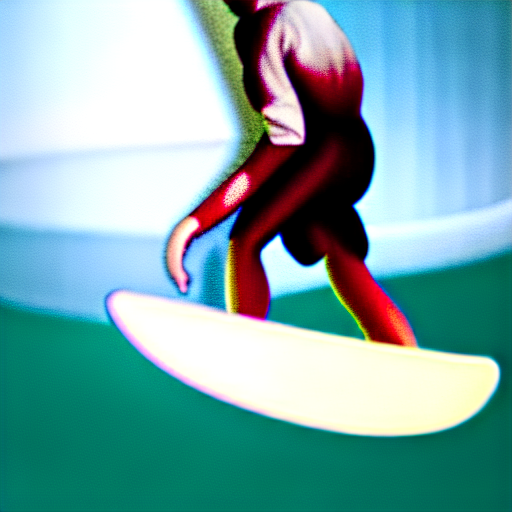

Image saved at /content/kcg-ml-sd1p4/output/sd2-notebook/disturbed_embeddings/images/generated_image_alpha_0.89.png
Sample...[DONE]	3,582.74ms


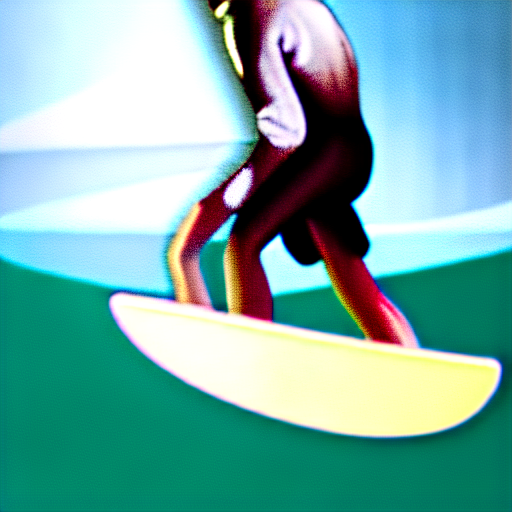

Image saved at /content/kcg-ml-sd1p4/output/sd2-notebook/disturbed_embeddings/images/generated_image_alpha_1.00.png


In [ ]:
import torch
from typing import List
import os
import sys
import math
from os.path import join


from stable_diffusion import StableDiffusion
from stable_diffusion.model_paths import IODirectoryTree
from configs.model_config import ModelPathConfig
from stable_diffusion.utils_backend import get_device, get_memory_status
from stable_diffusion.utils_image import to_pil, save_image_grid, show_image_grid
from configs.model_config import ModelPathConfig
from stable_diffusion import StableDiffusion, SDconfigs
from ga.model_clip_text import clip_text_get_prompt_embedding
from PIL import Image
from IPython.display import display

# Initialize some configurations
config = ModelPathConfig()
N_STEPS = 12


# Initialize directories
base_dir = "./"
sys.path.insert(0, base_dir)
EMBEDDED_PROMPTS_DIR = os.path.abspath(join(base_dir, "./input/embedded_prompts/"))
OUTPUT_DIR = os.path.abspath(join(base_dir, "./output/sd2-notebook/disturbed_embeddings/"))
IMAGES_DIR = os.path.abspath(join(OUTPUT_DIR, "images/"))

os.makedirs(EMBEDDED_PROMPTS_DIR, exist_ok=True)
os.makedirs(IMAGES_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)



# Other constants
NULL_PROMPT = ""
PROMPT1 = "a photograph of an astronaut riding harley davidson"
PROMPT2 = "a photograph of an astronaut surfing"
NUM_ITERATIONS = 16
SEED = 2982
BATCH_SIZE = 1

# Initialize device
DEVICE = get_device()

# Function for interpolating multiple steps
def interpolate_prompts(embedding1, embedding2, steps=10):
    interpolated_embeddings = []
    for i in range(steps):
        a = i / (steps - 1)
        interpolated_embedding = embedding2 * a + embedding1 * (1 - a)
        interpolated_embeddings.append(interpolated_embedding)
    return interpolated_embeddings


# Function to generate embeddings for each prompt
def prompt_embedding_vectors(config, prompt_array):
    embedded_prompts = clip_text_get_prompt_embedding(config, prompts=prompt_array)
    embedded_prompts.to("cpu")
    return embedded_prompts

# Initialize Stable Diffusion and load models
sd = StableDiffusion(device=DEVICE, n_steps=N_STEPS)
sd.quick_initialize().load_autoencoder(config.get_model(SDconfigs.VAE)).load_decoder(config.get_model(SDconfigs.VAE_DECODER))
sd.model.load_unet(config.get_model(SDconfigs.UNET))

# Embed the prompts using the new function
prompt_array = [PROMPT1, PROMPT2]
embedded_prompts = prompt_embedding_vectors(config, prompt_array)
embedding1, embedding2 = embedded_prompts[0], embedded_prompts[1]

# Save the embeddings
torch.save(embedding1, join(EMBEDDED_PROMPTS_DIR, "embedding1.pt"))
torch.save(embedding2, join(EMBEDDED_PROMPTS_DIR, "embedding2.pt"))

# Generate interpolated embeddings
steps = 10
interpolated_embeddings = interpolate_prompts(embedding1, embedding2, steps)

# Generate and save images
NULL_PROMPT = torch.zeros_like(embedding1)
CFG_STRENGTH = 12.0

for i, prompt_embedding in enumerate(interpolated_embeddings):
    alpha = i / (steps - 1)

    # Generate image latent and actual image from the prompt embedding
    try:
        latent = sd.generate_images_latent_from_embeddings(
            seed=SEED,
            embedded_prompt=prompt_embedding,
            null_prompt=NULL_PROMPT,
            uncond_scale=CFG_STRENGTH
        )
        image = sd.get_image_from_latent(latent)

        # Free up GPU memory
        del latent
        torch.cuda.empty_cache()

    except Exception as e:
        print(f"An error occurred: {e}")
        continue

    # Move prompt embedding back to CPU and free memory
    prompt_embedding.to("cpu")
    del prompt_embedding
    torch.cuda.empty_cache()

    # Save the image
    image_path = join(IMAGES_DIR, f"generated_image_alpha_{alpha:.2f}.png")
    pil_image = to_pil(image[0])

    # Free up GPU memory again
    del image
    torch.cuda.empty_cache()

    pil_image.save(image_path)

    # Display the image
    display(pil_image)

    print(f"Image saved at {image_path}")
